In [1]:
import data
import transport
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.spatial import distance_matrix
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
cdf = data.compas()

# white = cdf.loc[cdf['Caucasian'] == 1]
# black = cdf.loc[cdf['African-American'] == 1][:len(white)]
# hisp = cdf.loc[cdf['African-American'] == 1][:len(white)]

#Make Numpy
cdf_features = cdf.drop(["two_year_recid","y_pred", "custody_length", "c_jail_time", "is_recid", "decile_score"], axis=1)
X_a = cdf_features.to_numpy()
#Remove protected attributes 
X = preprocessing.scale(X_a[:,:-7])
Y_hat = cdf["y_pred"]
Y_truth = cdf["two_year_recid"]

In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, Y_hat)
print(clf.score(X, Y_hat))

clf2 = LogisticRegression(random_state=0).fit(X, Y_truth)
print(clf2.score(X, Y_truth))

0.7563188593648736
0.6796824368114064


In [4]:
biased_outcomes = clf.predict_proba(X)
# truth_outcomes = np.vstack([Y_truth, np.logical_not(Y_truth)]).T
truth_outcomes = clf2.predict_proba(X)
# truth_outcomes = np.vstack([np.zeros(len(X)), np.ones(len(X))]).T


In [5]:
T = transport.compute_map(truth_outcomes, biased_outcomes)
# T = transport.compute_entropic(truth_outcomes, biased_outcomes,.0020)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.


In [6]:
from graph import Map

In [7]:
f_columns = cdf_features.columns
column_ix = np.arange(len(f_columns))
f = {f_columns[i]: column_ix[i] for i in range(len(f_columns))}
f
from sklearn.preprocessing import normalize

In [8]:
f

{'sex': 0,
 'age': 1,
 'juv_fel_count': 2,
 'juv_misd_count': 3,
 'juv_other_count': 4,
 'priors_count': 5,
 'c_charge_degree': 6,
 'is_violent_recid': 7,
 'Other': 8,
 'African-American': 9,
 'Caucasian': 10,
 'Hispanic': 11,
 'Asian': 12,
 'Native American': 13}

In [9]:
clf.coef_ #trained on predicted labels 

array([[ 0.08410149, -1.07633706,  0.2826259 ,  0.2067717 ,  0.13172081,
         1.41654107,  0.18295592]])

In [10]:
clf2.coef_ #trained on the truth 

array([[-0.12781295, -0.51017664,  0.03357144, -0.00565955,  0.1290289 ,
         0.76994779,  0.10949602]])

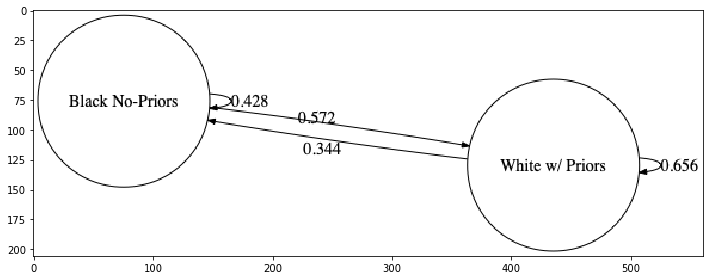

array([[0.42797362, 0.57202638],
       [0.343854  , 0.656146  ]])

In [11]:
# g = Map(transport_map=T, X1=X_a, symmetric=True)
g = Map(transport_map=np.multiply(T,distance_matrix(X,X)), X1=X_a, symmetric=True)
g.add_group(lambda x: x[f["priors_count"]] == 0 and x[f["African-American"]] == 1, "Black No-Priors")
g.add_group(lambda x: x[f["priors_count"]] > 0 and x[f["Caucasian"]] == 1, "White w/ Priors")
g.show_graph(grouped=True)
g.group_adj

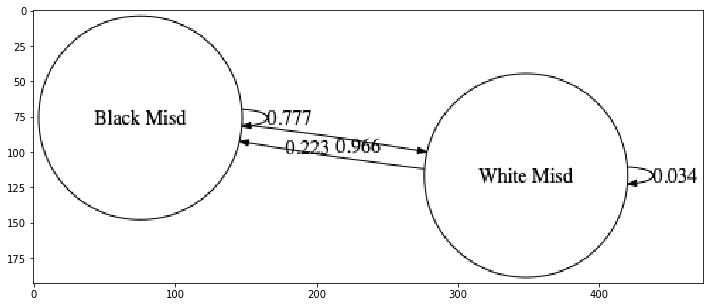

array([[0.77661067, 0.22338933],
       [0.96605086, 0.03394914]])

In [12]:
g = Map(transport_map=np.multiply(T,distance_matrix(X,X)), X1=X_a, symmetric=True)
g.add_group(lambda x: x[f["juv_misd_count"]] > 0 and x[f["African-American"]] == 1, "Black Misd")
g.add_group(lambda x: x[f["juv_misd_count"]] > 0 and x[f["Caucasian"]] == 1, "White Misd")
g.show_graph(grouped=True)
g.group_adj

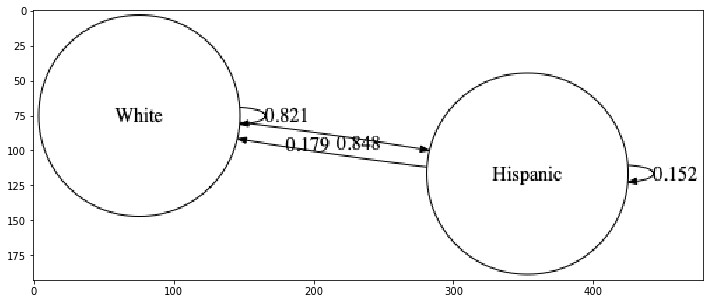

array([[0.82124465, 0.17875535],
       [0.8483394 , 0.1516606 ]])

In [13]:
# g = Map(transport_map=T, X1=X_a, symmetric=True)
g = Map(transport_map=np.multiply(T,distance_matrix(X,X)), X1=X_a, symmetric=True)
g.add_group(lambda x: x[f["Caucasian"]] == 1, "White")
g.add_group(lambda x: x[f["Hispanic"]] == 1, "Hispanic")
g.show_graph(grouped=True)
g.group_adj

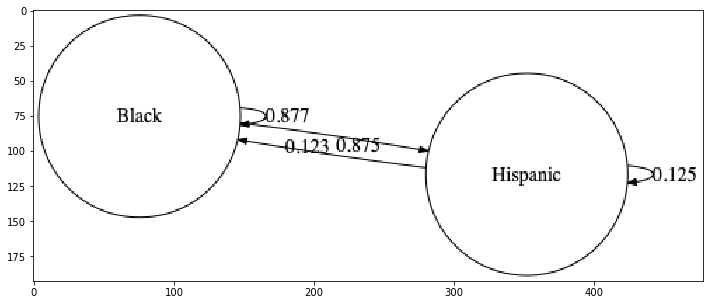

array([[0.87658537, 0.12341463],
       [0.87543253, 0.12456747]])

In [14]:
g = Map(transport_map=T, X1=X_a, symmetric=True)
g.add_group(lambda x: x[f["African-American"]] == 1, "Black")
g.add_group(lambda x: x[f["Hispanic"]] == 1, "Hispanic")
g.show_graph(grouped=True)
g.group_adj

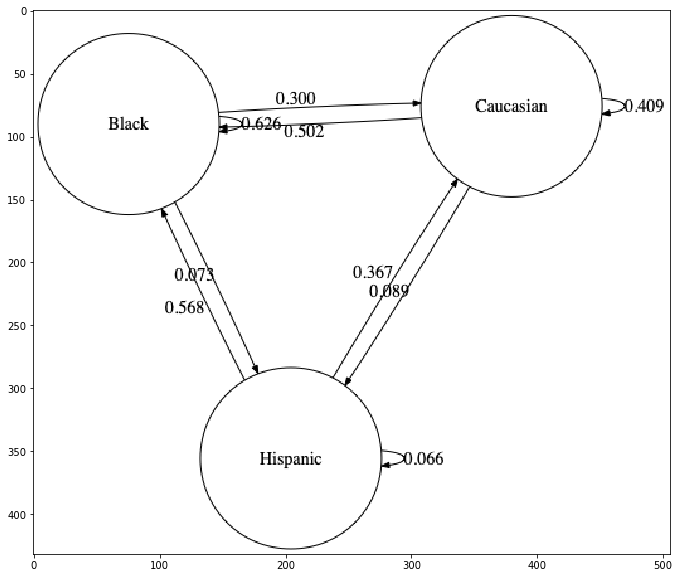

array([[0.62637313, 0.30022592, 0.07340095],
       [0.50195182, 0.40901941, 0.08902878],
       [0.56784575, 0.36661348, 0.06554077]])

In [15]:
# g = Map(transport_map=T, X1=X_a, symmetric=True)
g = Map(transport_map=np.multiply(T,distance_matrix(X,X)), X1=X_a, symmetric=True)
g.add_group(lambda x: x[f["African-American"]] == 1, "Black")
g.add_group(lambda x: x[f["Caucasian"]] == 1, "Caucasian")
g.add_group(lambda x: x[f["Hispanic"]] == 1, "Hispanic")
g.show_graph(grouped=True)
g.group_adj

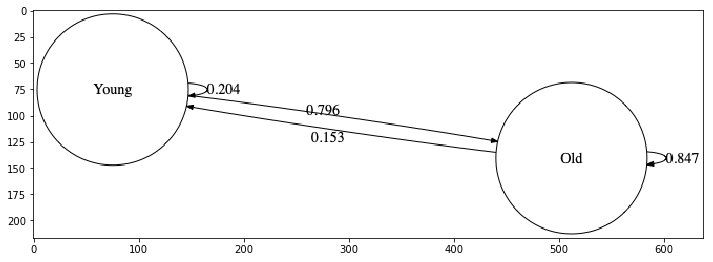

In [16]:
# g = Map(transport_map=T, X1=X_a, symmetric=True)
g = Map(transport_map=np.multiply(T,distance_matrix(X,X)), X1=X_a, symmetric=True)
g.add_group(lambda x: x[f["age"]] <= 23, "Young")
g.add_group(lambda x: x[f["age"]] > 23, "Old")
g.show_graph(grouped=True)

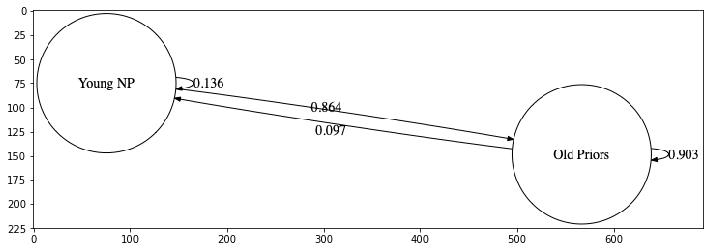

In [17]:
# g = Map(transport_map=T, X1=X_a, symmetric=True)
g = Map(transport_map=np.multiply(T,distance_matrix(X,X)), X1=X_a, symmetric=True)

g.add_group(lambda x: x[f["age"]] <= 23 and x[f['priors_count']] == 0, "Young NP")
g.add_group(lambda x: x[f["age"]] > 23 and x[f['priors_count']] > 0, "Old Priors")
g.show_graph(grouped=True)

In [18]:
uf = np.sum(np.multiply(T,distance_matrix(X,X)), axis=1)
edm_X = distance_matrix(X,X) 

Y_dist = distance_matrix(biased_outcomes, truth_outcomes)
edm_ep = distance_matrix(X,X) + np.identity(len(X))/10e9

uf2 = np.sum(np.multiply(np.divide(Y_dist,edm_ep),T), axis=1)

# uf = np.sum(np.multiply(edm,T), axis=1)

<ipython-input-18-e3037754b255>:7: RuntimeWarning: divide by zero encountered in true_divide
<ipython-input-18-e3037754b255>:7: RuntimeWarning: invalid value encountered in multiply


In [19]:
np.divide(Y_dist,edm_ep)

<ipython-input-19-ad6a2462319a>:1: RuntimeWarning: divide by zero encountered in true_divide


array([[1.37246533e+09, 1.65010956e-01, 2.13580681e-01, ...,
        2.20172430e-01, 1.06617601e-01, 1.39690622e-01],
       [6.19988537e-02, 1.70121520e+09, 2.58872751e-01, ...,
        4.94691700e-02, 4.84203643e-02, 1.21459548e-01],
       [2.10986211e-01, 2.40647843e-01, 1.25660521e+09, ...,
        2.35651795e-01, 1.48729361e-01, 1.26641825e-01],
       ...,
       [1.00496475e-01, 2.33540912e-01, 2.53623198e-01, ...,
        1.90803832e+09, 1.14610880e-01, 1.60094170e-01],
       [9.59873204e-02, 2.42146166e-02, 9.50704294e-02, ...,
        8.86759772e-02, 8.89230645e+08, 3.63315290e-02],
       [1.66267624e-01, 1.54919159e-01, 1.07277525e-02, ...,
        1.78443441e-01, 1.91299080e-01, 2.62029503e+09]])

In [20]:
cdf['uf_scores'] = uf
cdf['policy'] = biased_outcomes[:,1]
cdf['truth'] = truth_outcomes[:,1]
# cdf['lip_scores'] = uf2

In [21]:
cdf = cdf.reset_index(drop=True)
cdf

sex  age  juv_fel_count  decile_score  juv_misd_count  juv_other_count  \
0       0   69              0             1               0                0   
1       0   34              0             3               0                0   
2       0   24              0             4               0                1   
3       0   44              0             1               0                0   
4       0   41              0             6               0                0   
5       0   43              0             4               0                0   
6       1   39              0             1               0                0   
7       0   27              0             4               0                0   
8       0   23              0             6               0                0   
9       1   37              0             1               0                0   
10      0   41              0             4               0                0   
11      1   47              0             1               0                0   
12      0   31              0             3               0                0   
13      0   37              0             1               0                0   
14      0   25              0            10               0                0   
15      0   31              0             5               0                0   
16      0   31              0             3               0                0   
17      0   64              0             6               0                0   
18      0   21              0             9               0                0   
19      0   27              0             2               0                0   
20      1   21              0             4               0                0   
21      0   24              0             4               0                0   
22      0   43              0             1               0                0   
23      0   32              0             3               0                0   
24      0   27              0             3               0                0   
25      0   26              0             7               0                1   
26      0   33              0            10               0                0   
27      0   30              0             9               0                0   
28      0   32              0             8               0                0   
29      0   55              0             1               0                0   
30      0   49              0             3               0                0   
31      1   33              0             5               0                0   
32      0   24              0             2               0                0   
33      0   34              2             9               1                3   
34      0   29              0             2               0                0   
35      1   21              0             8               0                0   
36      0   51              0             1               0                0   
37      0   29              0             2               0                0   
38      1   51              0             2               0                0   
39      0   29              0             7               0                0   
40      0   25              0            10               0                0   
41      0   35              1             8               0                4   
42      0   49              0             1               0                0   
43      0   29              0             4               0                0   
44      0   29              0             2               0                0   
45      1   28              0             2               0                0   
46      0   31              0             5               0                1   
47      0   24              0             4               0                0   
48      0   30              0             7               0                0   
49    

In [22]:
cdf.sort_values(by=['uf_scores'], ascending=False).head(10)

sex  age  juv_fel_count  decile_score  juv_misd_count  juv_other_count  \
6055    0   22              0             4               1                0   
1525    0   25             20            10               0                0   
948     0   33              0             9               0                0   
3913    1   28              0             9               0                0   
101     0   33              0             8              12                2   
2647    0   25              0             9              13                1   
3939    0   33              0             9               0                0   
3186    0   36             10             7               0                0   
2394    0   24              0            10               1                9   
6160    0   30              0            10               1                0   

      priors_count  c_charge_degree  is_recid  is_violent_recid  \
6055             8                1         1                 1   
1525            24                1         1                 1   
948             16                1         1                 0   
3913            13                1         1                 0   
101             28                1         1                 0   
2647            21                1         1                 0   
3939            16                0         1                 1   
3186            14                1         1                 0   
2394             2                1         1                 0   
6160            19                1         1                 0   

      two_year_recid  y_pred c_jail_time custody_length  Other  \
6055               1   False     45.9817            128  False   
1525               1    True     20.8092            129   True   
948                1    True     21.2286              5  False   
3913               1    True     32.3678              5  False   
101                1    True       21.02              1  False   
2647               1    True     135.218            104  False   
3939               1    True     33.0467             33  False   
3186               1    True      194.24            368  False   
2394               1    True     263.907            242   True   
6160               1    True       15.32              9  False   

      African-American  Caucasian  Hispanic  Asian  Native American  \
6055              True      False     False  False            False   
1525             False      False     False  False            False   
948               True      False     False  False            False   
3913              True      False     False  False            False   
101               True      False     False  False            False   
2647              True      False     False  False            False   
3939              True      False     False  False            False   
3186              True      False     False  False            False   
2394             False      False     False  False            False   
6160              True      False     False  False            False   

      uf_scores    policy     truth  
6055   0.007019  0.940214  0.775039  
1525   0.007000  1.000000  0.994310  
948    0.004250  0.976333  0.887803  
3913   0.004020  0.970597  0.813580  
101    0.004005  0.999997  0.988204  
2647   0.003907  0.999991  0.966248  
3939   0.003512  0.965703  0.862940  
3186   0.003496  0.999870  0.911942  
2394   0.003213  0.964381  0.933591  
6160   0.003153  0.995064  0.935509

In [23]:
M = transport.compute_dist(truth_outcomes, biased_outcomes)

In [24]:
num = 20
cdf.iloc[[num,np.nonzero(T[num])[0][0]]]

sex  age  juv_fel_count  decile_score  juv_misd_count  juv_other_count  \
20      1   21              0             4               0                0   
5368    1   28              0             3               0                0   

      priors_count  c_charge_degree  is_recid  is_violent_recid  \
20               0                1         0                 0   
5368             0                1         0                 0   

      two_year_recid  y_pred c_jail_time custody_length  Other  \
20                 0   False     4.68667              1  False   
5368               0   False     191.853              6  False   

      African-American  Caucasian  Hispanic  Asian  Native American  \
20               False       True     False  False            False   
5368              True      False     False  False            False   

      uf_scores    policy     truth  
20     0.000097  0.563872  0.417689  
5368   0.000497  0.404819  0.345988

In [25]:
black = cdf.loc[cdf['African-American'] == 1]
black_score = black["uf_scores"].sum()/len(black)
black_score

0.00044549605007365717

In [26]:
white = cdf.loc[cdf['Caucasian'] == 1]
white_score = white["uf_scores"].sum()/len(white)
white_score

0.00039488992525752456

In [27]:
(black_score - white_score)/black_score

0.11359500226268116